In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('air_data_train.csv').drop(columns=['Unnamed: 0','co','no2','so2','dew']).fillna(0.0)

In [2]:
city_type = {
    'Samut Prakan': 'Peripheral',
    'Nakhon Ratchasima': 'Major',
    'Surin': 'Peripheral',
    'Sakon Nakhon': 'Peripheral',
    'Mueang Khon Kaen': 'Major',
    'Nong Khai': 'Peripheral',
    'Kanchanaburi': 'Major',
    'Suphan Buri': 'Peripheral',
    'Uthai Thani': 'Peripheral',
    'Nakhon Sawan': 'Peripheral',
    'Phitsanulok': 'Peripheral',
    'Kamphaeng Phet': 'Peripheral',
    'Lamphun': 'Peripheral',
    'Lampang': 'Peripheral',
    'Phayao': 'Peripheral',
    'Bangkok': 'Major',
    'Trat': 'Peripheral',
    'Nonthaburi': 'Peripheral',
    'Nan': 'Peripheral',
    'Ubon Ratchathani': 'Peripheral',
    'Samut Sakhon': 'Peripheral',
    'Chiang Mai': 'Major',
    'Mueang Chiang Rai': 'Peripheral',
    'Ayutthaya': 'Peripheral',
    'Uttaradit': 'Peripheral',
    'Rayong': 'Major',
    'Pathum Thani': 'Peripheral',
    'Chonburi': 'Major',
    'Nakhon Pathom': 'Peripheral',
    'Ratchaburi': 'Peripheral',
    'Phuket': 'Major',
    'Yala': 'Peripheral',
    'Krabi': 'Peripheral',
    'Trang': 'Peripheral',
    'Satun': 'Peripheral',
    'Pattani': 'Peripheral',
    'Narathiwat': 'Peripheral',
    'Prachuap Khiri Khan': 'Peripheral',
    'Saraburi': 'Peripheral',
}

In [5]:
def create_lag_features(df, group_col='City', time_col='time', label_col='pm25', lags=3):
    df = df.sort_values([group_col, time_col])
    feature_cols = df.columns.difference([group_col, time_col])

    for col in feature_cols:
        for lag in range(1, lags + 1):
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)

    df = df.dropna()
    return df
df_lagged = create_lag_features(df, lags=1, label_col='pm25')
df_lagged

,City,time,h,o3,p,pm10,pm25,r,t,w,h_lag1,o3_lag1,p_lag1,pm10_lag1,pm25_lag1,r_lag1,t_lag1,w_lag1
1,Ayutthaya,2025-02-20,39.500000,5.2,1011.150000,64.0,104.500000,0.5,29.8,2.50,39.500000,5.2,1011.150000,64.0,104.500000,0.5,29.8,2.50
2,Ayutthaya,2025-02-21,84.800000,5.2,1011.400000,64.0,138.000000,0.5,25.8,1.00,39.500000,5.2,1011.150000,64.0,104.500000,0.5,29.8,2.50
3,Ayutthaya,2025-02-22,53.633333,5.2,1013.266667,64.0,82.666667,0.5,28.4,0.90,84.800000,5.2,1011.400000,64.0,138.000000,0.5,25.8,1.00
4,Ayutthaya,2025-02-23,38.700000,5.2,1013.150000,64.0,92.500000,0.5,31.5,2.30,53.633333,5.2,1013.266667,64.0,82.666667,0.5,28.4,0.90
5,Ayutthaya,2025-02-24,10.000000,5.2,1016.900000,64.0,42.000000,0.5,28.5,5.10,38.700000,5.2,1013.150000,64.0,92.500000,0.5,31.5,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,Yala,2025-04-07,8.150000,0.0,1004.200000,33.0,37.500000,0.2,31.0,1.75,8.200000,0.0,1008.300000,33.0,33.000000,0.1,30.7,2.00
1764,Yala,2025-04-08,66.500000,0.0,1008.000000,33.0,46.000000,0.2,31.4,3.60,8.150000,0.0,1004.200000,33.0,37.500000,0.2,31.0,1.75
1765,Yala,2025-04-09,7.900000,0.0,1009.500000,33.0,42.000000,0.4,31.8,3.00,66.500000,0.0,1008.000000,33.0,46.000000,0.2,31.4,3.60
1766,Yala,2025-04-10,7.500000,0.0,1005.800000,33.0,39.000000,0.2,32.6,3.60,7.900000,0.0,1009.500000,33.0,42.000000,0.4,31.8,3.00


# autoregressive: lag only label

In [6]:
df = df.fillna(0.0)

In [7]:
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

def train_ar_models(df, lags=5, label_col='pm25'):
    df_lagged = create_lag_features(df, lags=lags, label_col=label_col)
    
    models = {}
    coefs = {}
    scores = {}

    for city, group in df_lagged.groupby('City'):
        pm25_lag_cols = [col for col in group.columns if col.startswith(f'{label_col}_lag')]
        X = group[pm25_lag_cols]
        y = group[label_col]

        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        model = LinearRegression().fit(X_train, y_train)
        score = root_mean_squared_error(y_test, model.predict(X_test))
        models[city] = model
        coefs[city] = pd.Series(model.coef_, index=pm25_lag_cols)
        scores[city] = score

    return models, coefs,scores


In [8]:
mean_scores = {}
for l in range(1,20):
    models, coefs, scores = train_ar_models(df, lags=l, label_col='pm25')
    mean_scores[l] = np.mean(list(scores.values()))
mean_scores

C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

{1: 22.1394302393707,
 2: 21.58022366165548,
 3: 21.638994480454784,
 4: 22.232161702031256,
 5: 22.557472859588454,
 6: 22.859100660019983,
 7: 23.036020250501537,
 8: 23.95208746571579,
 9: 24.74564481209343,
 10: 25.484034349558964,
 11: 26.73997513220813,
 12: 28.558174945568215,
 13: 30.11016498281534,
 14: 35.080426963910725,
 15: 41.964019966406916,
 16: 49.89200943034605,
 17: 63.01717782278788,
 18: 81.55581239129255,
 19: 106.79201666337818}

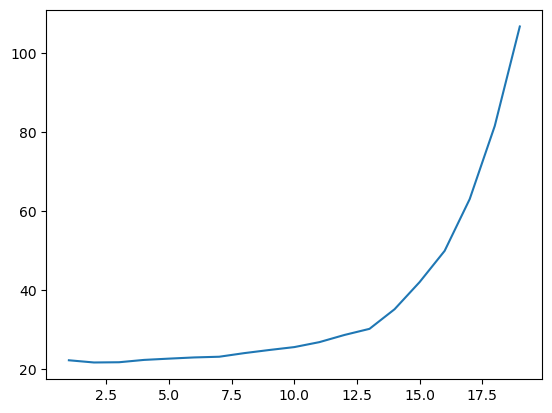

In [344]:
plt.plot(mean_scores.keys(), mean_scores.values())

In [10]:
models, coefs, scores = train_ar_models(df, lags=5, label_col='pm25')

coefMat = pd.DataFrame(coefs).T.reset_index(names='City')
coefMat['city_type'] = coefMat['City'].map(city_type)
maj = coefMat[coefMat['city_type']=='Major']
per = coefMat[coefMat['city_type']=='Peripheral']
import numpy as np
maj_mean = maj.mean(numeric_only=True)
per_mean = per.mean(numeric_only=True)
pd.concat([maj_mean, per_mean], axis=1, keys=['Major', 'Peripheral']).reset_index(names='feature').to_csv('LagOnlyLabel.csv', index=False)
pd.concat([maj_mean, per_mean], axis=1, keys=['Major', 'Peripheral'])

,Major,Peripheral
pm25_lag1,0.633383,0.735491
pm25_lag2,0.123117,0.037843
pm25_lag3,-0.043027,-0.009448
pm25_lag4,0.040260,-0.016954
pm25_lag5,-0.068527,-0.012655


Text(0.5, 1.0, 'Comparison of Average Coefficient Values\nin autoregressive model: Major vs Peripheral\nuse only lag of label value')

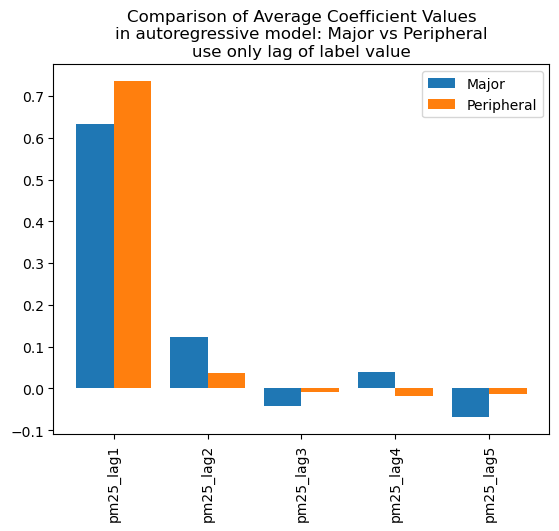

In [11]:
x = np.arange(len(maj_mean))

# Bar width
width = 0.4

# Plot
plt.bar(x - width/2, maj_mean.values, width=width, label='Major')
plt.bar(x + width/2, per_mean.values, width=width, label='Peripheral')
plt.xticks(x, maj_mean.index, rotation=90)
plt.legend()
plt.title("Comparison of Average Coefficient Values\nin autoregressive model: Major vs Peripheral\nuse only lag of label value")

# autoregressive: lag only label with exogenous input

In [12]:
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

def train_ar_models(df, lags=5, label_col='pm25'):
    df_lagged = create_lag_features(df, lags=lags, label_col=label_col)
    
    models = {}
    coefs = {}
    scores = {}

    for city, group in df_lagged.groupby('City'):
        y = group[label_col]
        X = group[['h', 'o3', 'p', 'pm10', 'r', 't', 'w']+[col for col in group.columns if col.startswith(f'{label_col}_lag')]]
        

        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        model = LinearRegression().fit(X_train, y_train)
        score = root_mean_squared_error(y_test, model.predict(X_test))
        models[city] = model
        coefs[city] = pd.Series(model.coef_, index=X.columns)
        scores[city] = score

    return models, coefs,scores

In [13]:
mean_scores = {}
all_scores = {}
for l in range(1,20):
    models, coefs, scores = train_ar_models(df, lags=l, label_col='pm25')
    all_scores[l] = scores
    mean_scores[l] = np.mean(list(scores.values()))
mean_scores

C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

{1: 18.84387841177974,
 2: 18.612839901070977,
 3: 19.160650781021417,
 4: 20.108583903695973,
 5: 20.46788651604951,
 6: 34.891258860961415,
 7: 38.02988529685987,
 8: 49.04212457454173,
 9: 50.15969986715023,
 10: 52.660509133269386,
 11: 113.03365113385648,
 12: 138.09951194636008,
 13: 157.44327167392137,
 14: 294.46753107881386,
 15: 337.84492765534344,
 16: 354.57388846762433,
 17: 1609.4492888122902,
 18: 4520.211796738222,
 19: 241.74392469396255}

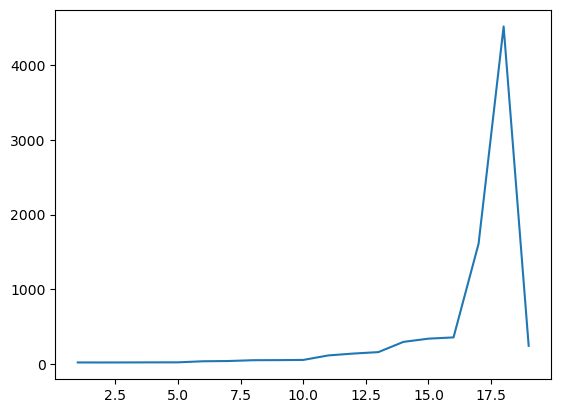

In [14]:
plt.plot(mean_scores.keys(), mean_scores.values())
plt.show()

In [15]:
models, coefs, scores = train_ar_models(df, lags=5, label_col='pm25')
coefMat = pd.DataFrame(coefs).T.reset_index(names='City')
coefMat['city_type'] = coefMat['City'].map(city_type)
coefMat
maj = coefMat[coefMat['city_type']=='Major']
per = coefMat[coefMat['city_type']=='Peripheral']
import numpy as np
maj_mean = maj.mean(numeric_only=True)
per_mean = per.mean(numeric_only=True)
pd.concat([maj_mean, per_mean], axis=1, keys=['Major', 'Peripheral']).reset_index(names='feature').to_csv('LagOnlyLabel woth exo.csv', index=False)
pd.concat([maj_mean, per_mean], axis=1, keys=['Major', 'Peripheral'])

,Major,Peripheral
h,-0.010209,-0.017862
o3,0.368352,0.504867
p,0.715732,0.605288
pm10,0.444802,0.564209
r,-0.084965,-0.047655
t,1.127773,0.460947
w,-4.027186,-1.910959
pm25_lag1,0.359150,0.463358
pm25_lag2,-0.020703,-0.006893
pm25_lag3,0.001304,-0.030067


Text(0.5, 1.0, 'Comparison of Average Coefficient Values\nin autoregressive model: Major vs Peripheral\nuse only lag of label value and exogenoeus input')

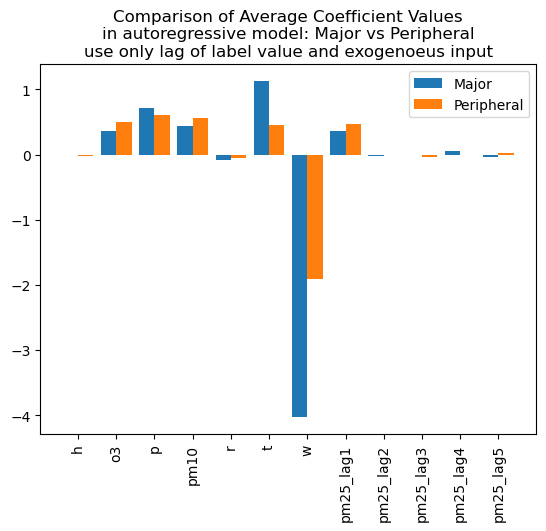

In [16]:
x = np.arange(len(maj_mean))

# Bar width
width = 0.4

# Plot
plt.bar(x - width/2, maj_mean.values, width=width, label='Major')
plt.bar(x + width/2, per_mean.values, width=width, label='Peripheral')
plt.xticks(x, maj_mean.index, rotation=90)
plt.legend()
plt.title("Comparison of Average Coefficient Values\nin autoregressive model: Major vs Peripheral\nuse only lag of label value and exogenoeus input")

# lag all variables

In [17]:
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

def train_ar_models(df, lags=5, label_col='pm25'):
    df_lagged = create_lag_features(df, lags=lags, label_col=label_col)
    
    models = {}
    coefs = {}
    scores = {}

    for city, group in df_lagged.groupby('City'):
        y = group[label_col]
        X = group[[col for col in group.columns if 'lag' in col]]
        

        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        model = LinearRegression().fit(X_train, y_train)
        score = root_mean_squared_error(y_test, model.predict(X_test))
        models[city] = model
        coefs[city] = pd.Series(model.coef_, index=X.columns)
        scores[city] = score

    return models, coefs,scores

In [18]:
mean_scores = {}
all_scores = {}
for l in range(1,20):
    models, coefs, scores = train_ar_models(df, lags=l, label_col='pm25')
    all_scores[l] = scores
    mean_scores[l] = np.mean(list(scores.values()))
mean_scores

C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
C:\Users\yamch\AppData\Local\Temp\ipykernel_19528\435002328.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

{1: 24.896803916227057,
 2: 28.961894780977392,
 3: 34.780745343684934,
 4: 52.16422371333893,
 5: 141.82967270277229,
 6: 264.22085578830286,
 7: 91.04885770162038,
 8: 83.40279741708692,
 9: 64.50483018489486,
 10: 68.43038851187309,
 11: 60.43475848965133,
 12: 48.99048361647786,
 13: 53.12453719031723,
 14: 52.37373232331445,
 15: 48.07029891847069,
 16: 45.37577793750074,
 17: 43.762846842001025,
 18: 45.57774648702415,
 19: 46.11863842651077}

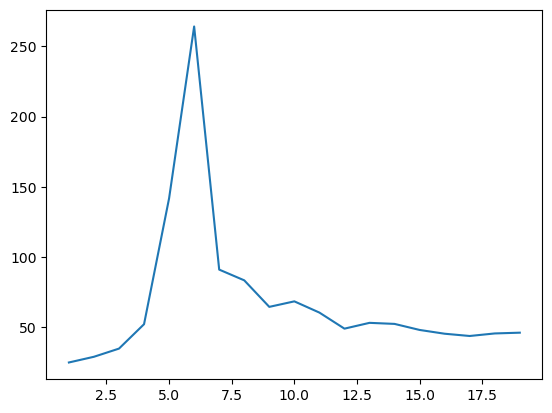

In [19]:
plt.plot(mean_scores.keys(), mean_scores.values())
plt.show()

In [20]:
models, coefs, scores = train_ar_models(df, lags=4, label_col='pm25')
coefMat = pd.DataFrame(coefs).T.reset_index(names='City')
coefMat['city_type'] = coefMat['City'].map(city_type)
coefMat
maj = coefMat[coefMat['city_type']=='Major']
per = coefMat[coefMat['city_type']=='Peripheral']
maj

,City,h_lag1,h_lag2,h_lag3,h_lag4,o3_lag1,o3_lag2,o3_lag3,o3_lag4,p_lag1,...,r_lag4,t_lag1,t_lag2,t_lag3,t_lag4,w_lag1,w_lag2,w_lag3,w_lag4,city_type
1,Bangkok,0.587364,0.257009,0.598697,0.405193,4.423425e+00,3.987070e+00,7.164686e+00,-5.469872e-01,-5.163162,...,-0.824851,-12.150111,-18.832427,-8.731225,7.324342,8.810375,7.914287,2.819256,2.569179,Major
2,Chiang Mai,-0.133604,-0.929447,-0.215473,0.170290,4.374279e-14,-2.418066e-13,-4.085621e-14,8.082424e-14,1.685580,...,-0.228078,3.032812,-0.334372,-2.415470,2.588804,-21.167793,-14.442117,-31.024745,-8.499221,Major
3,Chonburi,-0.061590,-0.103133,0.108077,0.198223,1.787459e-14,3.852474e-14,3.724798e-14,3.408385e-14,-2.795603,...,-0.123879,-2.171641,0.192611,2.719243,-0.694590,12.148289,9.005294,7.581814,5.333744,Major
4,Kanchanaburi,-0.854027,-0.279689,-0.366145,-0.111513,-8.459899e-14,-7.105427e-15,4.662937e-14,-2.531308e-14,-2.080122,...,0.231935,-2.649785,-2.540543,-7.148746,1.601311,8.496205,-1.669926,9.306236,13.869393,Major
8,Mueang Khon Kaen,-0.327243,-0.278567,0.297247,0.077279,-2.853273e-14,-1.576517e-14,-4.174439e-14,1.665335e-14,0.560758,...,-0.319072,-1.572362,1.549014,-0.120281,1.777861,-1.093924,-5.036541,-26.244059,-9.911033,Major
10,Nakhon Ratchasima,0.038970,-0.338060,-0.207366,-0.054257,2.823658e+00,2.497254e+00,1.824078e+00,-2.981436e+00,-3.145376,...,0.207189,-4.541676,-4.691171,-1.372012,2.683759,-9.287258,-5.786672,7.326333,9.796030,Major
19,Phuket,0.044786,-0.083952,0.258508,-0.317734,-2.786660e-14,-1.650069e-14,7.618906e-15,-2.975398e-14,4.302261,...,0.042931,2.808638,-2.320668,2.403011,-3.738986,-0.863270,-1.030025,-9.623503,4.440944,Major
22,Rayong,-0.159628,0.039931,0.004570,0.092747,7.882583e-15,7.271961e-15,-2.775558e-15,-5.606626e-15,3.957411,...,0.065913,-3.181230,-0.882004,0.880372,5.349388,-1.972622,0.629401,-4.816873,-1.474630,Major


In [21]:
per

,City,h_lag1,h_lag2,h_lag3,h_lag4,o3_lag1,o3_lag2,o3_lag3,o3_lag4,p_lag1,...,r_lag4,t_lag1,t_lag2,t_lag3,t_lag4,w_lag1,w_lag2,w_lag3,w_lag4,city_type
0,Ayutthaya,0.752682,-0.028030,-0.139629,-0.107006,1.421085e-14,-8.770762e-15,-1.210143e-14,-1.465494e-14,0.818958,...,9.005467e-01,-0.551466,1.470567,1.888637,4.464259,-3.613104,-5.130415,0.402519,-10.733613,Peripheral
5,Lampang,-0.162532,-0.223391,0.048685,0.179339,-1.776357e-14,5.723200e-14,2.109424e-15,2.220446e-14,0.243880,...,4.219992e-01,3.555049,0.262564,1.486209,3.874222,0.099119,12.931870,8.610907,8.146929,Peripheral
6,Lamphun,-0.767714,-0.327195,-0.117038,-0.847949,1.594171e+00,-4.035378e+00,1.420362e+00,-1.878984e+00,0.486359,...,-5.865679e-01,-0.464796,-1.736814,0.395067,0.263432,3.257552,5.956962,1.124600,-1.760821,Peripheral
7,Mueang Chiang Rai,-3.064016,-0.090745,0.107402,-4.635683,-1.376677e-14,-4.440892e-15,-7.993606e-15,-4.440892e-16,-1.345934,...,2.220446e-16,-4.389619,0.482864,-0.781210,-12.575176,-0.969553,-5.323018,3.290100,10.915391,Peripheral
9,Nakhon Pathom,0.353901,-0.600923,0.398730,0.285666,1.265654e-13,5.773160e-15,-6.461498e-14,-3.552714e-14,4.020547,...,-3.631102e-01,6.952461,-13.280587,-3.804339,3.257321,-10.194645,20.009241,-12.323101,10.009508,Peripheral
11,Nakhon Sawan,-0.131076,0.189862,0.024037,0.370082,1.648519e-14,-5.633806e-14,1.344118e-14,-4.197827e-14,0.684780,...,-2.200470e-01,-0.367589,-1.001803,-0.738088,3.133061,-0.519996,2.869192,-16.581404,23.965085,Peripheral
12,Nan,-0.241231,0.231581,0.354672,-0.734057,-4.914024e+01,-8.442214e+01,-4.476851e+01,-7.570256e+01,-0.849569,...,-5.692004e-02,-1.644750,-1.604423,4.356580,-1.143975,13.289759,0.700493,1.052178,5.414989,Peripheral
13,Narathiwat,0.064120,-0.067460,0.070226,-0.184289,1.565414e-14,-9.547918e-15,-3.488876e-14,-1.887379e-15,1.989171,...,-3.333337e-02,6.417138,-0.876548,1.787781,-4.753183,-3.132460,-0.574313,-0.904346,1.755714,Peripheral
14,Nong Khai,0.344778,1.022154,-0.376319,-0.211000,8.407634e+00,6.210409e+00,7.180933e+00,-8.398153e+00,-0.766395,...,4.642439e-01,-1.527766,-1.334067,0.642866,2.718467,6.697383,-17.037543,20.868850,-17.051364,Peripheral
15,Nonthaburi,-0.596791,-0.476743,0.446020,-2.147854,6.851612e-16,-1.012939e-14,-3.542656e-15,-1.432931e-14,5.656211,...,0.000000e+00,1.449286,-6.679206,5.194423,-3.234750,-6.225116,-1.385111,5.240390,7.068247,Peripheral


In [22]:
import numpy as np
maj_mean = maj.mean(numeric_only=True)
per_mean = per.mean(numeric_only=True)
pd.concat([maj_mean, per_mean], axis=1, keys=['Major', 'Peripheral']).reset_index(names='feature').to_csv('Lag all input.csv', index=False)
pd.concat([maj_mean, per_mean], axis=1, keys=['Major', 'Peripheral'])

,Major,Peripheral
h_lag1,-0.108121,-0.180349
h_lag2,-0.214488,-0.024147
h_lag3,0.059764,0.069785
h_lag4,0.057528,-0.329859
o3_lag1,0.905885,-1.074062
o3_lag2,0.810540,-2.538537
o3_lag3,1.123595,-1.531527
o3_lag4,-0.441053,-3.558182
p_lag1,-0.334782,1.561272
p_lag2,-1.303408,-1.414189


Text(0.5, 1.0, 'Comparison of Average Coefficient Values\nin autoregressive model: Major vs Peripheral\nuse lag of all input')

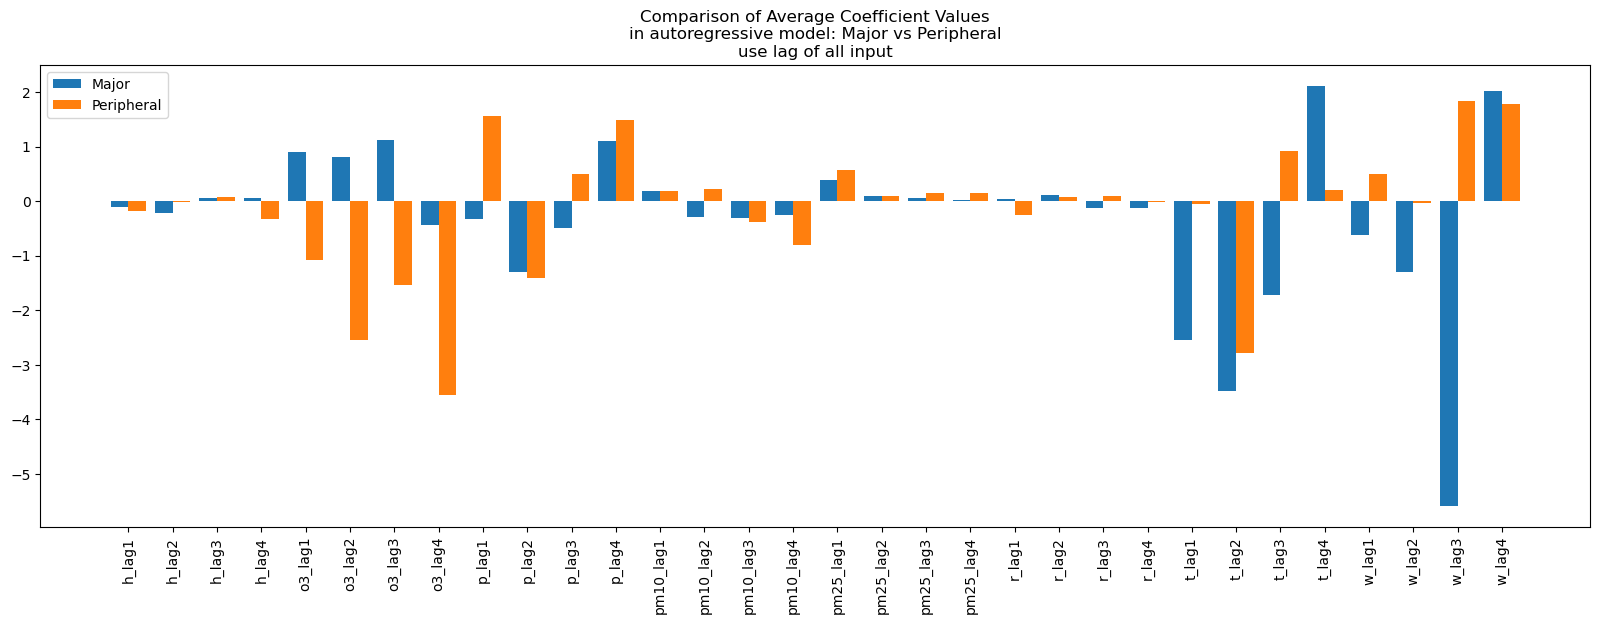

In [23]:
x = np.arange(len(maj_mean))

# Bar width
width = 0.4

# Plot
plt.figure(figsize=(20,6))
plt.bar(x - width/2, maj_mean.values, width=width, label='Major')
plt.bar(x + width/2, per_mean.values, width=width, label='Peripheral')
plt.xticks(x, maj_mean.index, rotation=90)
plt.legend()
plt.title("Comparison of Average Coefficient Values\nin autoregressive model: Major vs Peripheral\nuse lag of all input")